In [11]:
import pandas as pd
import os
import cv2
import numpy as np

from sklearn.svm import SVC

from datetime import datetime
import time

from sklearn.metrics import make_scorer, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def get_model_metrics(test_data, model, model_name):
    '''''''''
    Get binary classification metrics for a given model and saves the results to local directory
    '''''''''
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = model.predict_proba(test_data[0])
    predicted_probs = predicted_probs[:, 1]
    true_labels = test_data[1]
    predicted_labels = model.predict(test_data[0])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [13]:
X_train = np.loadtxt("GLCM_CIR/GLCM_CIR_noaug/X_train_CIR_noaug.csv", delimiter=",")
y_train = np.loadtxt('GLCM_CIR/GLCM_CIR_noaug/y_train_CIR_noaug.csv', delimiter=",")
X_test = np.loadtxt('GLCM_CIR/GLCM_CIR_noaug/X_test_CIR_noaug.csv', delimiter=",")
y_test = np.loadtxt('GLCM_CIR/GLCM_CIR_noaug/y_test_CIR_noaug.csv', delimiter=",")

In [14]:
scorer = make_scorer(f1_score, pos_label=1)

In [15]:
import time
s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'kernel': ['rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 0.5],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Best Score: 0.1321572871572872
46.494938135147095


In [16]:
best_params = grid_search.best_params_

In [17]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

In [18]:
best_svc_clf.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', gamma=0.1, probability=True, random_state=42)

Best threshold: 0.06 with F1-score: 0.14


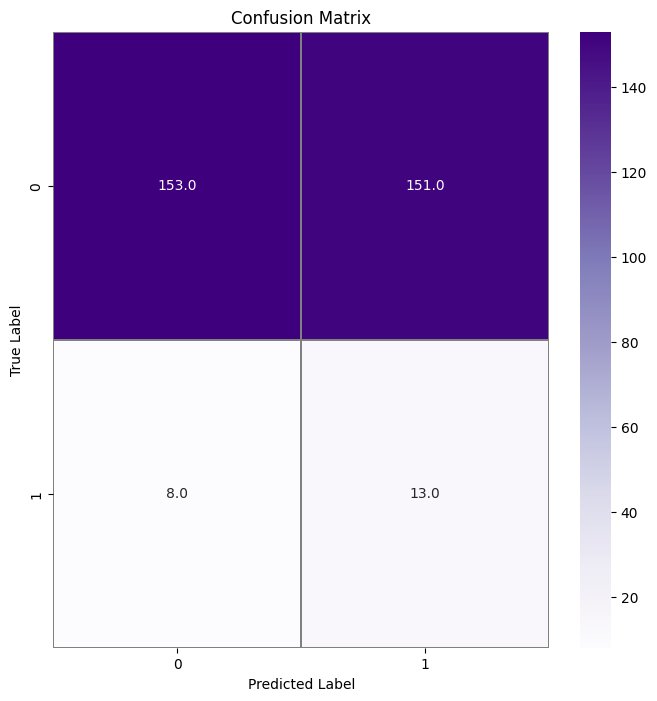

              precision    recall  f1-score   support

         0.0       0.95      0.50      0.66       304
         1.0       0.08      0.62      0.14        21

    accuracy                           0.51       325
   macro avg       0.51      0.56      0.40       325
weighted avg       0.89      0.51      0.62       325

           Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-SVC-noaug-poly  0.55                     0.14      0.51         0.62  \

   Specificity   PPV   NPV   PLR   NLR  
0          0.5  0.08  0.95  1.25  0.76  


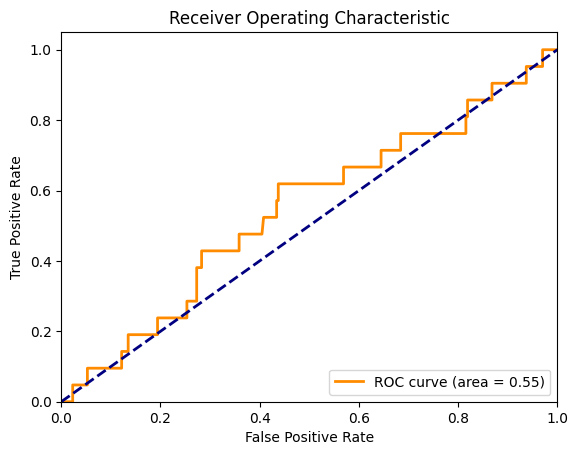

In [19]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='CIR-SVC-noaug-poly')

In [20]:
import time
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=LinearSVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 1, 'class_weight': 'balanced'}
Best Score: 0.07710582774223748
8.887240171432495


In [21]:
best_params = grid_search.best_params_

In [22]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

In [23]:
best_svc_clf.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', probability=True, random_state=42)

Best threshold: 0.00 with F1-score: 0.12


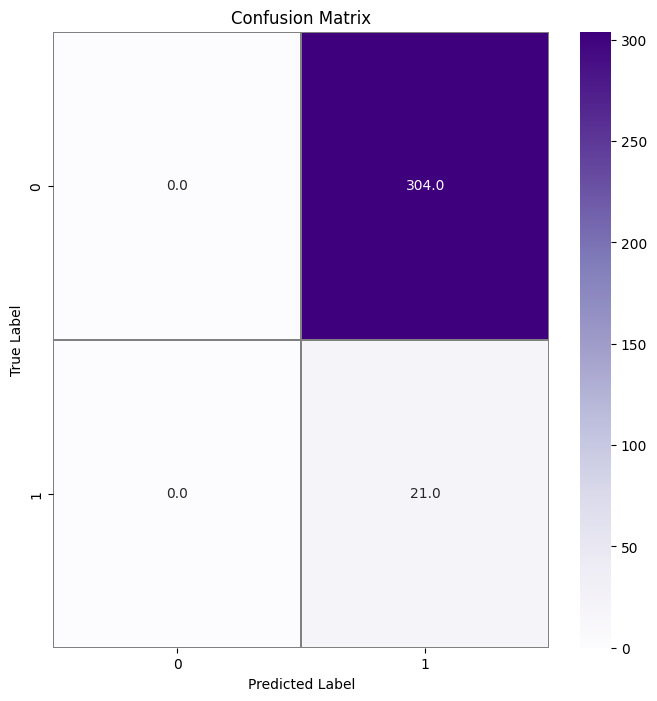

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       304
         1.0       0.06      1.00      0.12        21

    accuracy                           0.06       325
   macro avg       0.03      0.50      0.06       325
weighted avg       0.00      0.06      0.01       325

             Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-SVC-noaug-linear  0.42                     0.12      0.06          1.0  \

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.06  NaN  1.0  NaN  


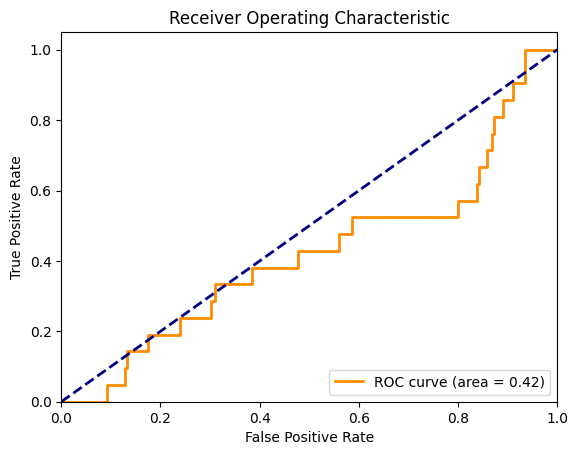

In [24]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='CIR-SVC-noaug-linear')